In [ ]:
import tensorflow as tf
import numpy as np

# Define the PDE
def pde(x, y, u, du_dx, du_dy):
    return tf.math.reduce_sum(tf.gradients(tf.gradients(u, x)[0], x) + tf.gradients(tf.gradients(u, y)[0], y), axis=0) - tf.exp(-x) * (x - 2 + y**3 + 6*y)

# Define the boundary conditions
def bc(x, y):
    return tf.exp(-x) * (x**2 + y**3 + 2*y)

# Generate training data
def generate_training_data(num_points):
    x = tf.random.uniform([num_points, 1], 0, 1)
    y = tf.random.uniform([num_points, 1], 0, 1)
    u = tf.zeros_like(x)
    return [x, y], u

# import numpy as np

# def generate_training_data(n):
#     # Generate n random points in the rectangular domain [0, 1] × [0, 1]
#     x = tf.random.uniform([n, 1], 0, 1)
#     y = tf.random.uniform([n, 1], 0, 1)  

#     # Compute the true values of Ψ(x, y) at each point using finite differences
#     dx = 1/99
#     dy = 1/99
#     A = np.zeros((99**2, 99**2))
#     b = np.zeros((99**2, 1))
#     for i in range(99):
#         for j in range(99):
#             index = i*99 + j
#             A[index, index] = -4*(dx**-2 + dy**-2)
#             if i == 0 or i == 98:
#                 A[index, index+99] = dx**-2
#                 A[index+99, index] = dx**-2
#                 b[index, 0] += -np.exp(-i*dx*(i*dx-2+j*dy**3+6*j*dy))*10/dx**2
#             if j == 0 or j == 98:
#                 A[index, index+1] = dy**-2
#                 A[index+1, index] = dy**-2
#                 b[index, 0] += -np.exp(-i*dx*(i*dx-2+j*dy**3+6*j*dy))*10/dy**2
#     u = np.linalg.solve(A, b).flatten()
#     u_train = np.zeros((n, 1))
#     for i in range(n):
#         ix = int(x[i] * 99)
#         iy = int(y[i] * 99)
#         u_train[i, 0] = u[iy + ix*99]

#     return [x, y], u_train



# Create the neural network
model = tf.keras.Sequential([
    tf.keras.layers.Dense(10, activation='tanh', input_shape=(2,)),
    tf.keras.layers.Dense(1, activation=None)
])

# Define the loss function
def loss_fn(y_true, y_pred):
    return tf.reduce_mean(tf.square(y_true - y_pred))

# Define the optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

# Compile the model
model.compile(loss=loss_fn, optimizer=optimizer)






In [ ]:

# Train the model using the NBM
for i in range(1000):
    x_boundary = tf.random.uniform([50, 1], 0, 1)
    y_boundary = tf.random.uniform([50, 1], 0, 1)
    is_boundary = tf.logical_or(tf.equal(x_boundary, 0), tf.equal(x_boundary, 1))
    is_boundary = tf.logical_or(is_boundary, tf.logical_or(tf.equal(y_boundary, 0), tf.equal(y_boundary, 1)))
    xy_train, u_train = generate_training_data(1000)
    with tf.GradientTape(persistent=True) as tape:
        u_boundary = bc(x_boundary, y_boundary)
        x_train = xy_train[0]
        y_train = xy_train[1]
        u_nn = model(tf.concat([x_train, y_train], axis=-1))
        u = tf.concat([u_boundary, u_nn], axis=0)
        tape.watch(u_nn)
        loss = loss_fn(u_train, u_nn)
        gradients = tape.gradient(loss, tape.watched_variables())
        gradients_u_nn = gradients[-3:]
    del tape
    optimizer.apply_gradients(zip(gradients_u_nn, model.trainable_variables[-3:]))


31250/31250 [==============================] - 52s 2ms/step


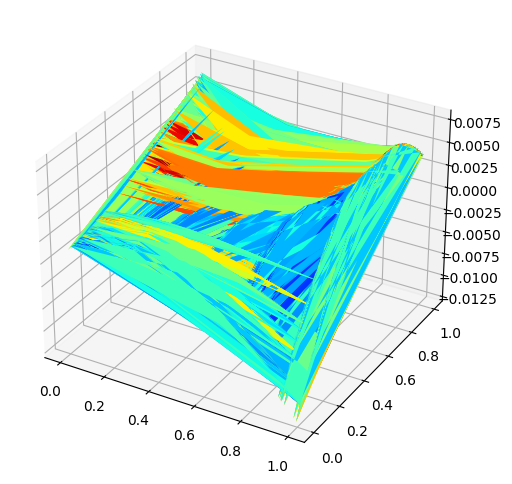

In [ ]:
# Generate a grid of points in the x-y plane
x_vals = np.linspace(0, 1, 100)
y_vals = np.linspace(0, 1, 100)
x_mesh, y_mesh = np.meshgrid(x_train, y_train)
points = np.vstack([x_mesh.flatten(), y_mesh.flatten()]).T

# Use the trained neural network to make predictions at each point
u_pred = model.predict(points).reshape(x_mesh.shape)

# Plot the predictions
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x_mesh, y_mesh, u_pred, cmap='jet')
plt.show()
